<h1>Capstone Project - The Battle of Neighborhoods

<h2>Topic : Real Estate Analysis: Safest Neighborhood in London Borough</h2><br><b>Created By : Vatsal Vora <br><b>Date : 23/03/2020

### 1. Intoduction

This project aims at finding the <b>best borough in London for buying a new house for a family</b>, explore the districts in that borough, find the  most common venues in each district and finally cluster the neighborhoods using k-mean clustering. Data that might contribute to determining the best borough include how safe the neighborhood is, affordability, accessibility and facilities like parks, restaurants etc. 
This report is mainly targeting <b>the expats who are considering to relocate to London</b> as part of career change could utilise this report for finding a safe borough and district in London for buying/renting a house. People who are currently in London, but has not invested in a house yet due to the current political/economical scenario, could also use this report.

### 2. Data

Following data sources are considered during the course of the project preparation:
1. To find all the boroughs in London :https://en.wikipedia.org/wiki/List_of_London_boroughs.
2. To get the crime records in London Boroughs:  https://www.kaggle.com/jboysen/london-crime.
3. Check the affordability of the houses using a dataset from Office for National Statistics: https://webarchive.nationalarchives.gov.uk/20171102125110/https://visual.ons.gov.uk/wp-content/uploads/2017/10/map.csv
4. To get the happiness index of London borough: https://www.itv.com/news/london/2016-08-16/londons-happiest-boroughs-revealed-as-richmond-hits-the-top-spot/. 
5. To find the districts in Sutton, which is the best borough for buying a house: https://en.wikipedia.org/wiki/London_Borough_of_Sutton#Districts
6. To get the most common venues in each district of Sutton:  The geographical cordinated are obtained using <b>geopy client.</b> And the happenening venues using <b>Foursquare Location Data</b>.

#### 2.1 To find all the boroughs in London :
Details can be obtained from the wiki page https://en.wikipedia.org/wiki/List_of_London_boroughs.
Expected output: <b>A dataframe with the borough names of London</b>

#### Importing the necessary libraries

In [1]:
import requests # library to handle requests
import bs4 # library for web scrapping
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import os # Library to get the current working directory
import json # Library  to parse JSON file into a Python dictionary

#!conda install -c conda-forge geocoder --yes
#import geocoder

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Plotting libraries
import matplotlib.cm as cm
import matplotlib.colors as colors

# Library for clustering algorithm
from sklearn.cluster import KMeans

# !pip install folium
# libraries for displaying maps
import folium 
import zipfile
print('Libraries imported.')

Libraries imported.


In [2]:
# Reading the JSON file for wiki page
web_link = 'https://en.wikipedia.org/wiki/List_of_London_boroughs'
response = requests.get(web_link)

try:
    response.raise_for_status()
    soup_obj = bs4.BeautifulSoup(response.text, 'html.parser')
    
except Exception as exc:
    print('Error while downloading the webpage.. %s' % exc)

In [3]:
# Getting the table containing the borough names
content = soup_obj.find('table', attrs={'class':"wikitable sortable"})
content

<table class="wikitable sortable" style="font-size:100%" width="100%">
<tbody><tr>
<th>Borough
</th>
<th>Inner
</th>
<th>Status
</th>
<th>Local authority
</th>
<th>Political control
</th>
<th>Headquarters
</th>
<th>Area (sq mi)
</th>
<th>Population (2013 est)<sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup>
</th>
<th>Co-ordinates
</th>
<th><span style="background:#67BCD3"> Nr. in map </span>
</th></tr>
<tr>
<td><a href="/wiki/London_Borough_of_Barking_and_Dagenham" title="London Borough of Barking and Dagenham">Barking and Dagenham</a> <sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[note 1]</a></sup>
</td>
<td>
</td>
<td>
</td>
<td><a href="/wiki/Barking_and_Dagenham_London_Borough_Council" title="Barking and Dagenham London Borough Council">Barking and Dagenham London Borough Council</a>
</td>
<td><a href="/wiki/Labour_Party_(UK)" title="Labour Party (UK)">Labour</a>
</td>
<td><a class="new" href="/w/index.php?title=Barking_Town_Hall&amp;action

In [4]:
# Using regex and getting the exact Borough names:

import re
column_name = ['London_Borough'] 
data_frame = pd.DataFrame(columns=column_name)

for row in content.findAll('tr'):
    line_item = row.findAll('td')
    if line_item:
        name1 = line_item[0].text.strip()
        re_obj = re.compile('\[')
        split_obj = re_obj.split(name1)
        borough_name = split_obj[0].strip()
        data_frame = data_frame.append({'London_Borough': borough_name},
                                        ignore_index=True)
        
data_frame

,London_Borough
0,Barking and Dagenham
1,Barnet
2,Bexley
3,Brent
4,Bromley
5,Camden
6,Croydon
7,Ealing
8,Enfield
9,Greenwich


### 2.2 Getting the crime record dataset

Datasource: Kaggle dataset for London crime data https://www.kaggle.com/jboysen/london-crime.
The dataset consist of:

1. lsoa_code: code for Lower Super Output Area in Greater London
2. borough: Common name for London borough.
3. major_category: High level categorization of crime
4. minor_category: Low level categorization of crime within major category.
5. value: monthly reported count of categorical crime in given borough
6. year: Year of reported counts, 2008-2016
7. month: Month of reported counts, 1-12

The csv file is read using pandas. Only the data from the year 2016 is extracted. If the 'value' column is 0, then is filtered out. Finally the dataset can be grouped together on borough name to get the count/crime rate.

In [6]:
zf = zipfile.ZipFile('london_crime_by_lsoa.csv.zip') 

In [7]:
csv_file = pd.read_csv(zf.open('london_crime_by_lsoa.csv'))
csv_file.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


In [8]:
# Consider the latest records only by filtering the year
df = csv_file[csv_file['year'] == 2016]
df.head(n=10)

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
9,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
14,E01002398,Hillingdon,Theft and Handling,Theft/Taking Of Motor Vehicle,0,2016,2
18,E01002945,Kingston upon Thames,Theft and Handling,Theft From Shops,0,2016,11
29,E01003325,Lewisham,Violence Against the Person,Common Assault,0,2016,2
32,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
36,E01002006,Haringey,Criminal Damage,Criminal Damage To Other Building,0,2016,12
64,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8


In [9]:
# Consider entry only if a crime if reported

df = df[df['value'] != 0].reset_index(drop=True)
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


#### 2.2 Finding the boroughs with affordable houses by checking the price per sq ft trends

Data source: Dataset from https://www.ons.gov.uk/ 
Link: https://webarchive.nationalarchives.gov.uk/20171102125110/https://visual.ons.gov.uk/wp-content/uploads/2017/10/map.csv')
The file contains:

1. local authority code
2. local authority name
3. year
4. price per m2 

Only local authority name which was extracted from the wiki page is filtered and taken into a dataset. 

In [10]:
house_price = pd.read_csv('https://webarchive.nationalarchives.gov.uk/20171102125110/https://visual.ons.gov.uk/wp-content/uploads/2017/10/map.csv')
house_price

,local authority code,local authority name,year,price per m2
0,E06000001,Hartlepool,2016,987
1,E06000002,Middlesbrough,2016,1120
2,E06000003,Redcar and Cleveland,2016,1182
3,E06000004,Stockton-on-Tees,2016,1254
4,E06000005,Darlington,2016,1260
5,E06000006,Halton,2016,1339
6,E06000007,Warrington,2016,1750
7,E06000008,Blackburn with Darwen,2016,1053
8,E06000009,Blackpool,2016,1107
9,E06000010,"Kingston upon Hull, City of",2016,1127


In [11]:
house_price = house_price.rename(columns={"local authority name": "London_Borough"})
house_price = house_price.drop(['local authority code','year'], axis=1)
house_price

,London_Borough,price per m2
0,Hartlepool,987
1,Middlesbrough,1120
2,Redcar and Cleveland,1182
3,Stockton-on-Tees,1254
4,Darlington,1260
5,Halton,1339
6,Warrington,1750
7,Blackburn with Darwen,1053
8,Blackpool,1107
9,"Kingston upon Hull, City of",1127


In [12]:
df_hp = pd.merge(data_frame, house_price, on='London_Borough')
df_hp = df_hp .sort_values(by = 'price per m2', ascending=True)
df_hp.set_index('London_Borough', inplace=True)
df_hp

,price per m2
London_Borough,
Barking and Dagenham,3994
Havering,4185
Bexley,4223
Croydon,4653
Redbridge,4957
Newham,4965
Sutton,5059
Bromley,5066
Enfield,5328


### 2.3 Checking the happiness index of the people in London Boroughs by a survey conducted by itv

For the happiness index, the itv page which contains the happiness index analysis is scrapped and the table with the values are extracted. Next string manipulation is done to get only the borough names in the decreasing order of happiness value. These datas are also converted into a dataframe

In [13]:
itv_link ='https://www.itv.com/news/london/2016-08-16/londons-happiest-boroughs-revealed-as-richmond-hits-the-top-spot/'
happy_ind = requests.get(itv_link)
happy_obj = bs4.BeautifulSoup(happy_ind.text, 'html.parser')

In [14]:
column_name = ['London_Borough'] 
happiness_index = pd.DataFrame(columns=column_name)

h1 = happy_obj.findAll(class_="item__content-block")
for table in h1:
    for list_obj in table.findAll('li'):
        b1 = list_obj.text.strip()
        borough_name = b1.split(',')[0]
        happiness_index = happiness_index.append({'London_Borough': borough_name},
                                        ignore_index=True)


## 3. Methodology 
The methodology in this project consists of two parts:

### 3.1Exploratory Data Analysis: 
3.1.1. Visualise the crime rates in the London boroughs to idenity the safest borough and extract the neighborhoods in that borough to find the 15 most common venues in each neighborhood.

3.1.2. Visualise the price per m2 in each boroughs of London and extract the 15 values with the least values.

3.1.3. Check the happiness index and get the one with top 15 values.

Compare the three results and find the best borough

### 3.2 Modelling: 
Once the borough is decided, we have to get the districts in that borough. To help people find similar neighborhoods in the borough, we will be clustering similar neighborhoods using K - means clustering that clusters data based on predefined cluster size. The cluster size can be determined using elbow method.
Once the clustring is done, people can shortlist the area of their interests based on the venues/amenities around each neighborhood.

#### 3.1.1 Analysis of crime data

In [15]:
print('Total number of entries in the crime data set for London boroughs for year 2016:', df.shape[0])
df.info()

Total number of entries in the crime data set for London boroughs for year 2016: 392042
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392042 entries, 0 to 392041
Data columns (total 7 columns):
lsoa_code         392042 non-null object
borough           392042 non-null object
major_category    392042 non-null object
minor_category    392042 non-null object
value             392042 non-null int64
year              392042 non-null int64
month             392042 non-null int64
dtypes: int64(3), object(4)
memory usage: 20.9+ MB


In [16]:
df.describe(include='all')

,lsoa_code,borough,major_category,minor_category,value,year,month
count,392042,392042,392042,392042,392042.000000,392042.0,392042.000000
unique,4835,33,7,28,NaN,NaN,NaN
top,E01033583,Lambeth,Theft and Handling,Harassment,NaN,NaN,NaN
freq,256,17605,129159,36213,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.877659,2016.0,6.543077
std,NaN,NaN,NaN,NaN,2.650033,0.0,3.423461
min,NaN,NaN,NaN,NaN,1.000000,2016.0,1.000000
25%,NaN,NaN,NaN,NaN,1.000000,2016.0,4.000000
50%,NaN,NaN,NaN,NaN,1.000000,2016.0,7.000000
75%,NaN,NaN,NaN,NaN,2.000000,2016.0,10.000000


In [17]:
# Getting the 15 Boroughs with least crime records in the year 2016

crime_count = df['borough'].value_counts()
df_c = crime_count.to_frame()
df_c.rename(columns={'borough': 'crime_count'}, inplace=True)
df_c.index.name = 'London_Borough'
df_c = df_c.sort_values(by = 'crime_count')
df_c = pd.merge(data_frame, df_c, on='London_Borough')
df_c = df_c .sort_values(by = 'crime_count', ascending=True)
df_c.set_index('London_Borough', inplace=True)
df_c = df_c[0:15]

In [18]:
# Visualising the result
import matplotlib.pyplot as plt

ax = df_c.plot(kind='bar',
               figsize= (15, 10),
               width= 0.8,
               fontsize= 14)

ax.set_title("Crime rates of various boroughs in London (2016)", fontsize=16)
ax.set_ylabel('Crime rate')
ax.set_xlabel('London Borough')

ax.legend(prop=dict(size=12))
for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        va = 'top'
        label = y_value

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Vertically shift label by `space`
            xytext= (0,14),
            textcoords="offset points",
            ha='center',                # Horizontally center label
            va=va,                      
            fontsize=14)           
                    

#### 3.1.2. Visualise the price per m2 in each boroughs of London and extract the 15 values with the least values.

In [19]:
df_hp.describe(include='all')

,price per m2
count,32.000000
mean,7473.187500
std,3423.874446
min,3994.000000
25%,5262.500000
50%,6510.000000
75%,8549.750000
max,19439.000000


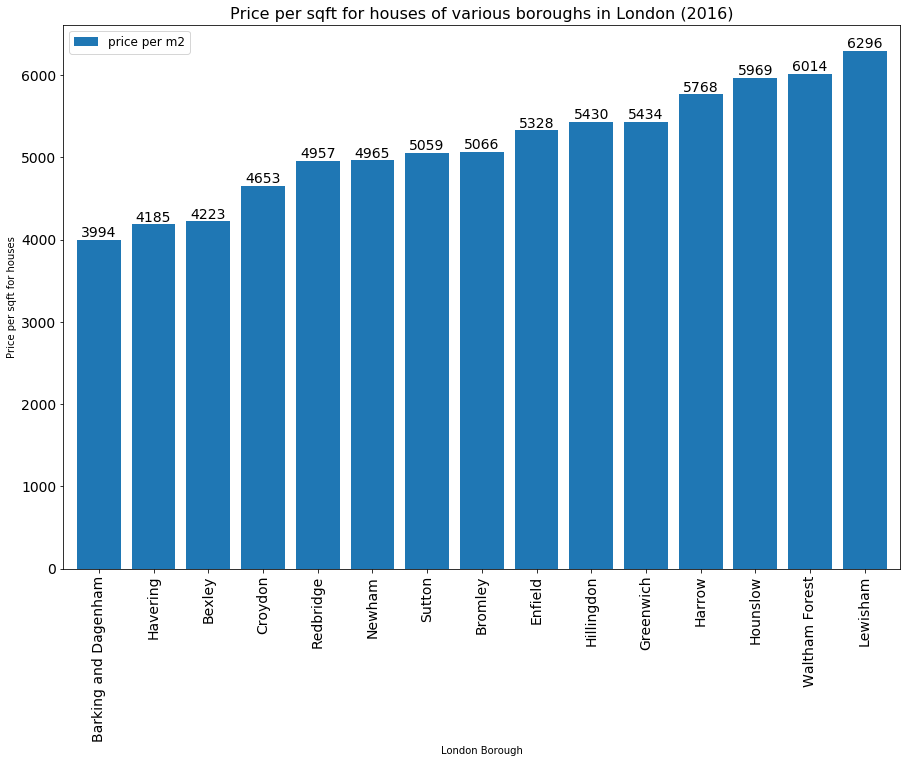

In [20]:
df_hp = df_hp[0:15]
ax = df_hp.plot(kind='bar',
               figsize= (15, 10),
               width= 0.8,
               fontsize= 14)

ax.set_title("Price per sqft for houses of various boroughs in London (2016)", fontsize=16)
ax.set_ylabel('Price per sqft for houses')
ax.set_xlabel('London Borough')

ax.legend(prop=dict(size=12))
for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        va = 'top'
        label = y_value

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Vertically shift label by `space`
            xytext= (0,14),
            textcoords="offset points",
            ha='center',                # Horizontally center label
            va=va,                      
            fontsize=14)           
                    

In [21]:
# Finding the boroughs which has least crime rates and most affordable houses
common_boroughs_c_hp = df_c.index.intersection(df_hp.index)
df_cb = pd.DataFrame(common_boroughs_c_hp)
df_cb

,London_Borough
0,Sutton
1,Bexley
2,Harrow
3,Havering
4,Barking and Dagenham
5,Redbridge
6,Bromley
7,Waltham Forest
8,Hounslow
9,Hillingdon


### 3.1.3. Check the happiness index and get the one with top 15 values.

In [22]:
df_hi = happiness_index[0:15]
df_hi

,London_Borough
0,Richmond Upon Thames
1,Kingston upon Thames
2,Bromley
3,Sutton
4,Wandsworth
5,Camden
6,Barnet
7,Ealing
8,Greenwich
9,Havering


In [23]:
# Check the happiness index of the above boroughs and find the best: 
df_cb.merge(df_hi)

,London_Borough
0,Sutton
1,Havering
2,Bromley
3,Waltham Forest


#### Considering the crime rates, affordability in terms of price per sq feet and the happiness index,  I have decided that theseboroughs in London are the best ones for buying a house: Sutton, Bromley, Havering, Waltham Forest, with 
### Sutton being the best choice. 
It has placed second in terms of least crime rate, seventh in affordability, which is much less than the mean value of houses in London(7473.1875) and fourth in happiness index.

#### Next, we will analyse the neighborhood of Sutton. For that we need all the disticts there. This can be obtained from the wiki: https://en.wikipedia.org/wiki/London_Borough_of_Sutton#Districts
The wiki page is scrapped and the details are extracted. Then, using the geopy client, we have to get the coordinate details.
Finally using the four square data, get the top venues.

#### Explore and cluster the neighborhoods in Sutton

In [24]:
district = []
borough_name = []

neighborhood_details = {}
sutton_wiki = 'https://en.wikipedia.org/wiki/London_Borough_of_Sutton#Districts'
sutton_response = requests.get(sutton_wiki)
sutton_soup_obj = bs4.BeautifulSoup(sutton_response.text, 'html.parser')
district_table = sutton_soup_obj.find(class_='div-col') 

for dist_det in district_table.findAll('li'):
    d1 = dist_det.text.strip()
    dist_name = d1.split('(')[0]
    district.append(dist_name)
    borough_name.append('Sutton')

In [25]:
latitude = []
longitude = []

for dist in district:
    address = '{},London,United Kingdom'.format(dist)
    geolocator = Nominatim(user_agent="London_agent", timeout=10)
    location = geolocator.geocode(address)
    if location:
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    else:
        latitude.append(np.nan)
        longitude.append(np.nan)

print(district,latitude, longitude)

['Bandon Hill', 'Beddington', 'Beddington Corner', 'Belmont', 'Benhilton', 'Carshalton', 'Carshalton Beeches', 'Carshalton on the Hill', 'Cheam', 'Hackbridge', 'Little Woodcote', 'North Cheam', 'Rosehill', 'St. Helier', 'South Beddington', 'Sutton ', 'Sutton Common', 'Sutton High Street ', 'The Wrythe', 'Wallington', 'Woodcote Green', 'Worcester Park'] [51.3647773, 51.3719875, 51.3869422, 51.3437847, 51.3716416, 51.3657883, 51.3571959, nan, 51.3576155, 51.3796135, 51.3460764, 51.3715776, 51.01250455, 51.3866947, 51.3719875, 51.3575114, 51.3753729, 51.3597647, 51.3670587, 51.357945, 51.3479908, 51.3783998] [-0.13483259828506877, -0.1323928, -0.1495322, -0.2011522, -0.1915714, -0.1610857, -0.1693507, nan, -0.2162414, -0.1567541, -0.1459324, -0.220225, -0.1406388422402289, -0.1800574, -0.1323928, -0.173640122600872, -0.1960317, -0.1909906, -0.1629561, -0.1495621, -0.1468304318627454, -0.2416023]


In [26]:
neighborhood_data = {'District': district,'Borough': borough_name, 'Latitude': latitude,'Longitude':longitude}
sutton_neighborhood = pd.DataFrame.from_dict(neighborhood_data)
sutton_neighborhood = sutton_neighborhood.dropna()
sutton_neighborhood

,District,Borough,Latitude,Longitude
0,Bandon Hill,Sutton,51.364777,-0.134833
1,Beddington,Sutton,51.371988,-0.132393
2,Beddington Corner,Sutton,51.386942,-0.149532
3,Belmont,Sutton,51.343785,-0.201152
4,Benhilton,Sutton,51.371642,-0.191571
5,Carshalton,Sutton,51.365788,-0.161086
6,Carshalton Beeches,Sutton,51.357196,-0.169351
8,Cheam,Sutton,51.357616,-0.216241
9,Hackbridge,Sutton,51.379613,-0.156754
10,Little Woodcote,Sutton,51.346076,-0.145932


## 3.2 Modelling

Modelling consists of the following steps:

3.2.1.Finding all the venues within a 500 meter radius of each neighborhood.

3.2.2.Perform one hot ecoding on the venues data.

3.2.3.Grouping the venues by the neighborhood and calculating their mean.

3.2.4.Performing a K-means clustering

### 3.2.1.Finding all the venues within a 500 meter radius of each neighborhood.

In [27]:
CLIENT_ID = 'XC0TXIKHUPYMRD0CCGFVCPILEDGMUC02ZVAHR5JSVPY4UMXW' # your Foursquare ID
CLIENT_SECRET = 'NN45CHWZFFZO5MAS1EDQHKIFTWL1DDUMMK3IH1PEKCA2EL5R' # your Foursquare Secret
VERSION = '20180605' 

In [28]:
radius = 500
limit = 100

In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
sutton_venues = getNearbyVenues(names=sutton_neighborhood['District'],
                                 latitudes=sutton_neighborhood['Latitude'],
                                 longitudes=sutton_neighborhood['Longitude']
                                )

In [31]:
print(sutton_venues.shape)
sutton_venues.head(n=10)

(184, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bandon Hill,51.364777,-0.134833,The Plough,51.367633,-0.132089,Pub
1,Bandon Hill,51.364777,-0.134833,Asif Balti House,51.367795,-0.132356,Indian Restaurant
2,Bandon Hill,51.364777,-0.134833,Mellows Park,51.360692,-0.134101,Park
3,Beddington,51.371988,-0.132393,Carew Manor,51.370983,-0.136604,Park
4,Beddington,51.371988,-0.132393,Wickes,51.375519,-0.130732,Hardware Store
5,Beddington,51.371988,-0.132393,Asif Balti House,51.367795,-0.132356,Indian Restaurant
6,Beddington,51.371988,-0.132393,The Plough,51.367633,-0.132089,Pub
7,Beddington Corner,51.386942,-0.149532,Traq,51.389091,-0.144979,Racetrack
8,Beddington Corner,51.386942,-0.149532,TNT Croydon Depot,51.389079,-0.144074,Business Service
9,Belmont,51.343785,-0.201152,Belmont Railway Station (BLM),51.343857,-0.198677,Train Station


In [32]:
print('The number of popular venues in each district of Sutton Borough are as follows:')
sutton_venues.groupby('District').count()

The number of popular venues in each district of Sutton Borough are as follows:


,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Bandon Hill,3,3,3,3,3,3
Beddington,4,4,4,4,4,4
Beddington Corner,2,2,2,2,2,2
Belmont,5,5,5,5,5,5
Benhilton,8,8,8,8,8,8
Carshalton,12,12,12,12,12,12
Carshalton Beeches,4,4,4,4,4,4
Cheam,24,24,24,24,24,24
Hackbridge,4,4,4,4,4,4


In [33]:
print('There are %d unique categories of venues in Sutton Borough' % len(sutton_venues['Venue Category'].unique()))
sutton_venues['Venue Category'].unique()

There are 57 unique categories of venues in Sutton Borough


array(['Pub', 'Indian Restaurant', 'Park', 'Hardware Store', 'Racetrack',
       'Business Service', 'Train Station', 'Chinese Restaurant',
       'Asian Restaurant', 'Playground', 'Gym / Fitness Center',
       'Supermarket', 'Coffee Shop', 'Pizza Place', 'Clothing Store',
       'Grocery Store', 'Hotel', 'Bus Stop', 'Bakery', 'Veterinarian',
       'Italian Restaurant', 'Thai Restaurant', 'Creperie',
       'American Restaurant', 'Gastropub', 'Stationery Store',
       'Salon / Barbershop', 'Restaurant', 'Soccer Field', 'River',
       'Garden Center', 'Construction & Landscaping', 'Social Club',
       'Seafood Restaurant', 'Turkish Restaurant', 'Fast Food Restaurant',
       'Breakfast Spot', 'Tennis Court', 'Athletics & Sports',
       'Portuguese Restaurant', 'Gym', 'Bookstore', 'Café',
       'French Restaurant', 'Bar', 'Sandwich Place', 'Irish Pub',
       'Tea Room', 'Pharmacy', 'Spanish Restaurant', 'Fish & Chips Shop',
       'BBQ Joint', 'Convenience Store', 'Cosmetics Shop

### 3.2.2.Perform one hot ecoding on the venues data.

#### Let's analyse each of these district now

In [34]:
sutton_onehot = pd.get_dummies(sutton_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
sutton_onehot['District'] = sutton_venues['District'] 
column_names = [sutton_onehot.columns[-1]] + list(sutton_onehot.columns[0:-1])
sutton_onehot = sutton_onehot[column_names]
sutton_onehot.head()

,District,American Restaurant,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Bus Stop,Business Service,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Fast Food Restaurant,Fish & Chips Shop,French Restaurant,Garden Center,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hotel,Indian Restaurant,Irish Pub,Italian Restaurant,Lebanese Restaurant,Park,Pet Service,Pet Store,Pharmacy,Pizza Place,Playground,Portuguese Restaurant,Pub,Racetrack,Restaurant,River,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Soccer Field,Social Club,Spanish Restaurant,Stationery Store,Supermarket,Tea Room,Tennis Court,Thai Restaurant,Train Station,Turkish Restaurant,Veterinarian
0,Bandon Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bandon Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bandon Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Beddington,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Beddington,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 3.2.3.Grouping the venues by the neighborhood and calculating their mean.

In [35]:
sutton_grouped = sutton_onehot.groupby("District").mean().reset_index()
sutton_grouped.head()

,District,American Restaurant,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Bookstore,Breakfast Spot,Bus Stop,Business Service,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Fast Food Restaurant,Fish & Chips Shop,French Restaurant,Garden Center,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hotel,Indian Restaurant,Irish Pub,Italian Restaurant,Lebanese Restaurant,Park,Pet Service,Pet Store,Pharmacy,Pizza Place,Playground,Portuguese Restaurant,Pub,Racetrack,Restaurant,River,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Soccer Field,Social Club,Spanish Restaurant,Stationery Store,Supermarket,Tea Room,Tennis Court,Thai Restaurant,Train Station,Turkish Restaurant,Veterinarian
0,Bandon Hill,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.00,0.0,0.333333,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.000,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
1,Beddington,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.25,0.0,0.250000,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.000,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
2,Beddington Corner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
3,Belmont,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.2,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.2,0.0,0.0
4,Benhilton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.125,0.00,0.0,0.125000,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.125,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0


#### Find out the top three venues in each neighborhood

In [36]:
num_top_venues = 3

for hood in sutton_grouped['District']:
    print("***********"+hood+"***********")
    temp = sutton_grouped[sutton_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

***********Bandon Hill***********
               venue  freq
0  Indian Restaurant  0.33
1               Park  0.33
2                Pub  0.33


***********Beddington***********
               venue  freq
0  Indian Restaurant  0.25
1     Hardware Store  0.25
2               Park  0.25


***********Beddington Corner***********
                 venue  freq
0     Business Service   0.5
1            Racetrack   0.5
2  American Restaurant   0.0


***********Belmont***********
              venue  freq
0  Asian Restaurant   0.2
1     Train Station   0.2
2        Playground   0.2


***********Benhilton***********
                  venue  freq
0     Indian Restaurant  0.12
1           Supermarket  0.12
2  Gym / Fitness Center  0.12


***********Carshalton***********
           venue  freq
0            Pub  0.17
1  Grocery Store  0.17
2   Veterinarian  0.08


***********Carshalton Beeches***********
           venue  freq
0  Train Station  0.25
1         Bakery  0.25
2  Grocery Store  0.25


***

#### Building a dataframe with the top venue category for each district in Sutton

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District'] = sutton_grouped['District']

for ind in np.arange(sutton_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sutton_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bandon Hill,Indian Restaurant,Park,Pub,Construction & Landscaping,Gym,Grocery Store,Gastropub,Garden Center,French Restaurant,Fish & Chips Shop
1,Beddington,Indian Restaurant,Park,Pub,Hardware Store,Construction & Landscaping,Gym,Grocery Store,Gastropub,Garden Center,French Restaurant
2,Beddington Corner,Business Service,Racetrack,Veterinarian,Construction & Landscaping,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center,French Restaurant
3,Belmont,Pub,Train Station,Asian Restaurant,Chinese Restaurant,Playground,Veterinarian,Gym,Grocery Store,Gastropub,Garden Center
4,Benhilton,Indian Restaurant,Supermarket,Grocery Store,Park,Pizza Place,Clothing Store,Coffee Shop,Gym / Fitness Center,Creperie,Gym


### 3.2.4. Clustering the similar neighborhood in Sutton using k-means algorithm

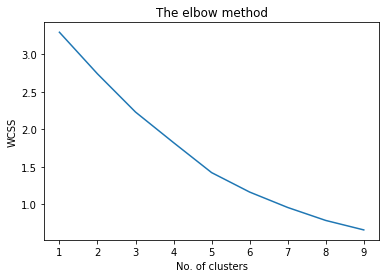

In [39]:
from sklearn.cluster import KMeans
wcss = []

sutton_grouped_clustering = sutton_grouped.drop('District', 1)

for i in range(1,10):
    kmeans = KMeans(n_clusters = i, init= 'k-means++', max_iter=2000, n_init=10, random_state =0)
    kmeans.fit(sutton_grouped_clustering)
    wcss.append(kmeans.inertia_) #calculate wcss and append it to a list
plt.plot(range(1,10), wcss)
plt.title('The elbow method')
plt.xlabel('No. of clusters')
plt.ylabel('WCSS')
plt.show()


### From the above elbow plot, we may group the districts in Sutton into 5 clusters

In [40]:
# run k-means clustering
kmeans = KMeans(n_clusters=6, random_state=0).fit(sutton_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 3, 0, 0, 0, 5, 0, 0, 2], dtype=int32)

In [41]:
neighborhoods_venues_sorted.iloc[0:0]
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted
sutton_merged = sutton_neighborhood

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
sutton_merged= sutton_merged.join(neighborhoods_venues_sorted.set_index('District'), on='District')

sutton_merged.head()

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bandon Hill,Sutton,51.364777,-0.134833,1,Indian Restaurant,Park,Pub,Construction & Landscaping,Gym,Grocery Store,Gastropub,Garden Center,French Restaurant,Fish & Chips Shop
1,Beddington,Sutton,51.371988,-0.132393,1,Indian Restaurant,Park,Pub,Hardware Store,Construction & Landscaping,Gym,Grocery Store,Gastropub,Garden Center,French Restaurant
2,Beddington Corner,Sutton,51.386942,-0.149532,3,Business Service,Racetrack,Veterinarian,Construction & Landscaping,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center,French Restaurant
3,Belmont,Sutton,51.343785,-0.201152,0,Pub,Train Station,Asian Restaurant,Chinese Restaurant,Playground,Veterinarian,Gym,Grocery Store,Gastropub,Garden Center
4,Benhilton,Sutton,51.371642,-0.191571,0,Indian Restaurant,Supermarket,Grocery Store,Park,Pizza Place,Clothing Store,Coffee Shop,Gym / Fitness Center,Creperie,Gym


### Map of Sutton with the district  and cluster details

In [42]:
address = 'Sutton,London,United Kingdom '

geolocator = Nominatim(user_agent="sutton_explorer", timeout=3)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sutton are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Sutton are 51.3575114, -0.173640122600872.


In [43]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sutton_merged['Latitude'], sutton_merged['Longitude'], sutton_merged['District'], sutton_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
        
map_clusters

### Examine the clusters

In [44]:
sutton_merged[sutton_merged['Cluster Labels'] == 0]

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Belmont,Sutton,51.343785,-0.201152,0,Pub,Train Station,Asian Restaurant,Chinese Restaurant,Playground,Veterinarian,Gym,Grocery Store,Gastropub,Garden Center
4,Benhilton,Sutton,51.371642,-0.191571,0,Indian Restaurant,Supermarket,Grocery Store,Park,Pizza Place,Clothing Store,Coffee Shop,Gym / Fitness Center,Creperie,Gym
5,Carshalton,Sutton,51.365788,-0.161086,0,Grocery Store,Pub,Veterinarian,Bus Stop,Park,Gym / Fitness Center,Coffee Shop,Hotel,Bakery,Train Station
8,Cheam,Sutton,51.357616,-0.216241,0,Italian Restaurant,Pub,Coffee Shop,Grocery Store,Indian Restaurant,Salon / Barbershop,Creperie,Gastropub,Gym / Fitness Center,Park
9,Hackbridge,Sutton,51.379613,-0.156754,0,Train Station,Supermarket,Park,River,Veterinarian,Coffee Shop,Grocery Store,Gastropub,Garden Center,French Restaurant
11,North Cheam,Sutton,51.371578,-0.220225,0,Coffee Shop,Gym / Fitness Center,Supermarket,Fast Food Restaurant,Seafood Restaurant,Soccer Field,Social Club,Turkish Restaurant,Grocery Store,Pub
12,Rosehill,Sutton,51.012505,-0.140639,0,Restaurant,Grocery Store,Business Service,Pub,Veterinarian,Gym,Gastropub,Garden Center,French Restaurant,Fish & Chips Shop
16,Sutton Common,Sutton,51.375373,-0.196032,0,Gym / Fitness Center,Train Station,Tennis Court,Athletics & Sports,Grocery Store,Park,Construction & Landscaping,Gym,Gastropub,Garden Center
17,Sutton High Street,Sutton,51.359765,-0.190991,0,Pub,Coffee Shop,Italian Restaurant,Bar,Café,Pizza Place,Bakery,Bookstore,French Restaurant,Irish Pub
18,The Wrythe,Sutton,51.367059,-0.162956,0,Pub,Café,Grocery Store,Park,Veterinarian,Train Station,Hotel,Tea Room,Bakery,Coffee Shop


#### The cluster one is biggest with 12 out of 21 neighborhoods; which contains Train station, restaurents, gym, pubs, pharmacy etc. This seems like a happening place of Sutton, with a lot of floating crowd.

In [45]:
sutton_merged[sutton_merged['Cluster Labels'] == 1]

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bandon Hill,Sutton,51.364777,-0.134833,1,Indian Restaurant,Park,Pub,Construction & Landscaping,Gym,Grocery Store,Gastropub,Garden Center,French Restaurant,Fish & Chips Shop
1,Beddington,Sutton,51.371988,-0.132393,1,Indian Restaurant,Park,Pub,Hardware Store,Construction & Landscaping,Gym,Grocery Store,Gastropub,Garden Center,French Restaurant
14,South Beddington,Sutton,51.371988,-0.132393,1,Indian Restaurant,Park,Pub,Hardware Store,Construction & Landscaping,Gym,Grocery Store,Gastropub,Garden Center,French Restaurant


#### Second cluster consist of Bandon Hill. It has garden, pubs, gym, museum etc

In [46]:
sutton_merged[sutton_merged['Cluster Labels'] == 2]

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Little Woodcote,Sutton,51.346076,-0.145932,2,Coffee Shop,Construction & Landscaping,Park,Garden Center,Gym / Fitness Center,Gym,Grocery Store,Gastropub,French Restaurant,Fish & Chips Shop
20,Woodcote Green,Sutton,51.347991,-0.146830,2,Coffee Shop,Park,Garden Center,Café,Construction & Landscaping,Gym / Fitness Center,Gym,Grocery Store,Gastropub,French Restaurant


#### Third cluster contains three districts which are well connected, with lot of train stations, parks, river, bakery, grocery stores etc. This could be a tourist destination.

In [47]:
sutton_merged[sutton_merged['Cluster Labels'] == 3]

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Beddington Corner,Sutton,51.386942,-0.149532,3,Business Service,Racetrack,Veterinarian,Construction & Landscaping,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center,French Restaurant


#### Fourth cluster is Beddington Corner which has a racetrack, business services and shops

In [48]:
sutton_merged[sutton_merged['Cluster Labels'] == 4]

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,St. Helier,Sutton,51.386695,-0.180057,4,Coffee Shop,Breakfast Spot,Construction & Landscaping,Gym / Fitness Center,Gym,Grocery Store,Gastropub,Garden Center,French Restaurant,Fish & Chips Shop


#### Fifth cluster consist of Bandon Hill with Gardens, pubs,museums etc.

In [49]:
sutton_merged[sutton_merged['Cluster Labels'] == 5]

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Carshalton Beeches,Sutton,51.357196,-0.169351,5,Train Station,Italian Restaurant,Grocery Store,Bakery,Veterinarian,Construction & Landscaping,Gym,Gastropub,Garden Center,French Restaurant
15,Sutton,Sutton,51.357511,-0.173640,5,Train Station,Grocery Store,Italian Restaurant,Bakery,Park,Veterinarian,Construction & Landscaping,Gym,Gastropub,Garden Center


#### Sixth cluster consisting of Little Woodcote & Woodcote Green has lots of garden, parks, coffee shop, gym and grocery stores. This seems like an idyllic place with lots of green space. 

In [50]:
sutton_merged[sutton_merged['Cluster Labels'] == 6]

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


<h2> Result and Discussion</h2>
<br>
While considering the move to London, we analysed the various boroughs based on crime rate and affordability in terms of price per square feet of the houses. I also came across a survey result by itv on the happiness index of the people in these boroughs. Considering the following factors, we concluded that Sutton, Bromley, Havering, Waltham Forest are the best boroughs for buying a house in London, with Sutton being the most ideal choice for me.

The next decision to be made was which is the best neighborhood for the house in Sutton. As a family of four, I wanted a place which has easy access to grocery stores, restaurants,gym etc. I also wanted a peaceful place with parks for my kids to have outdoor time and some coffee shops.

Using k-means clustering, I could find out that Sixth cluster which consists of Little Woodcote and Woodcote Green is the best place for me.

## Conclusion 

This project helps me get a better understanding of the neighborhoods with respect to the most common venues in that neighborhood. We have just taken safety, affordability and accessibity as the primary concerns to shortlist the borough of London. We also have issues in getting the latest dataset for analysis.

The future of this project includes taking  factors such as cost of living in the areas, employment rate, transportation etc into consideration to shortlist the borough.